In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 11.7MB/s 
     |████████████████████████████████| 1.1MB 51.4MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 194kB 47.8MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 40kB 7.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 2.6MB 47.8MB/s 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
https://open.spotify.com/playlist/37i9dQZF1EpsQlmU3Y7aK4?si=WT2eJU6iS6GwpXtNhhLDUg


ValueError: ignored

In [2]:
from fastbook import *

In [12]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y = parent_label, item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                  Normalize.from_stats(*imagenet_stats)],
  ).dataloaders(path, bs=128)

In [13]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)


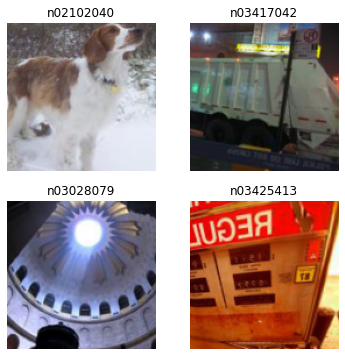

In [14]:
dls.show_batch(max_n=4)

In [15]:
def avg_pool(x):
  return x.mean((2,3))

In [16]:
def block(ni,nf):
  return ConvLayer(ni, nf, stride=2)

def get_model():
  return nn.Sequential(
      block(3,16),
      block(16,32),
      block(32,64),
      block(64,128),
      block(128,256),
      nn.AdaptiveAvgPool2d(1),
      Flatten(),
      nn.Linear(256, dls.c)
  )

In [17]:
def get_learner(m):
  return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [18]:
learn = get_learner(get_model())

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.005248074419796467)

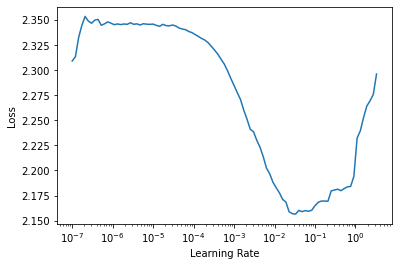

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.893617,1.969128,0.360510,00:25
1,1.536164,2.131697,0.402293,00:25
2,1.281668,1.365709,0.572994,00:25
3,1.128549,1.076970,0.662166,00:25
4,1.038328,1.061718,0.670828,00:25


## Building a Mordern CNN: ResNet

The key thing is that those 36 extra layers, as they stand, are an *identity mapping*, but they have *parameters*, which means they are *trainable*. So, we can start with our best 20-layer model, add these 36 extra layers which initially do nothing at all, and then *fine-tune the whole 56-layer model*. Those extra 36 layers can then learn the parameters that make them most useful.

 If the outcome of a given layer is x, when using a ResNet block that returns y = x+block(x) we're not asking the block to predict y, we are asking it to predict the difference between y and x. So the job of those blocks isn't to predict certain features, but to minimize the error between x and the desired y. A ResNet is, therefore, good at learning about slight differences between doing nothing and passing though a block of two convolutional layers (with trainable weights). This is how these models got their name: they're predicting residuals (reminder: "residual" is prediction minus target).

In [21]:
class ResBlock(Module):
  def __init__(self, ni, nf):
    self.convs = nn.Sequential(
        ConvLayer(ni, nf),
        ConvLayer(nf, nf, norm_type=NormType.BatchZero)
    )
  
  def forward(self, x):
    return x + self.convs(x)

In [22]:
def _conv_block(ni, nf, stride):
  return nn.Sequential(
      ConvLayer(ni,nf, stride=stride),
      ConvLayer(nf, nf, act_cls=None,norm_type=NormType.BatchZero)
  )

In [23]:
class ResBlock(Module):
  def __init__(self, ni,nf, stride=1):
    self.convs = _conv_block(ni, nf, stride)
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
  
  def forward(self, x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [24]:
def block(ni, nf):
  return ResBlock(ni, nf, stride=2)

learn = get_learner(get_model())

In [25]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.970053,1.822328,0.376306,00:27
1,1.672599,1.618146,0.485860,00:27
2,1.360750,1.260903,0.602038,00:26
3,1.126275,1.038614,0.673885,00:26
4,0.997338,0.992349,0.690446,00:26


if we need a deeper model we just replace our block with two ResBlocks in a row

In [26]:
def block(ni,nf):
  return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [27]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.961717,1.825339,0.376306,00:28
1,1.609523,1.539008,0.498599,00:28
2,1.299576,1.085937,0.650446,00:27
3,1.060887,0.949432,0.695287,00:27
4,0.924933,0.908587,0.706242,00:27


## State of the Art Resnet

In [30]:
def _resnet_stem(*sizes):
  return [
          ConvLayer(sizes[i], sizes[i+1], 3, stride=2 if i==0 else 1)
            for i in range(len(sizes)-1)
  ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [31]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

The reason that we have a stem of plain convolutional layers, instead of ResNet blocks, is based on a very important insight about all deep convolutional neural networks: the vast majority of the computation occurs in the early layers. Therefore, we should keep the early layers as fast and simple as possible.




In [36]:
class ResNet(nn.Sequential):
  def __init__(self, n_out, layers, expansion=1):
    stem = _resnet_stem(3,32,32,64)
    self.block_szs = [64,64,128,256,512]
    for i in range(1,5):
      self.block_szs[i] *= expansion
    blocks = [self._make_layer(*o) for o in enumerate(layers)]
    super().__init__(*stem, *blocks, nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(self.block_szs[-1], n_out))

  
  def _make_layer(self, idx, n_layers):
    stride = 1 if idx==0 else 2
    ch_in, ch_out = self.block_szs[idx:idx + 2]
    return nn.Sequential(*[ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1) for i in range(n_layers)])

The reason that we have a stem of plain convolutional layers, instead of ResNet blocks, is based on a very important insight about all deep convolutional neural networks: the vast majority of the computation occurs in the early layers. Therefore, we should keep the early layers as fast and simple as possible.

In [37]:
rn = ResNet(dls.c, [2,2,2,2])

In [38]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.713120,1.948376,0.407898,00:28
1,1.341251,1.665299,0.481019,00:28
2,1.089977,1.020883,0.667006,00:28
3,0.901071,0.875603,0.718217,00:28
4,0.773683,0.793919,0.745987,00:28


## replacing ResBlock with bottleneck

In [40]:
def _conv_block(ni, nf, stride):
  return nn.Sequential(
      ConvLayer(ni, nf//4, 1),
      ConvLayer(nf//4, nf//4, stride=stride),
      ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero)
  )

In [41]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

In [42]:
rn =  ResNet(dls.c, [3,4,6,3],4)

In [ ]:
learn = get_learner(rn)
learn.fit_one_cycle(20,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.624898,1.463593,0.529936,01:14
1,1.377434,2.524220,0.428790,01:14
2,1.237633,1.689494,0.522548,01:14
3,1.175466,2.096961,0.449936,01:14
4,1.058448,2.011186,0.529936,01:14
5,0.929843,1.096429,0.677707,01:13
6,0.856563,1.741622,0.511338,01:13
7,0.783368,1.743914,0.543440,01:13
